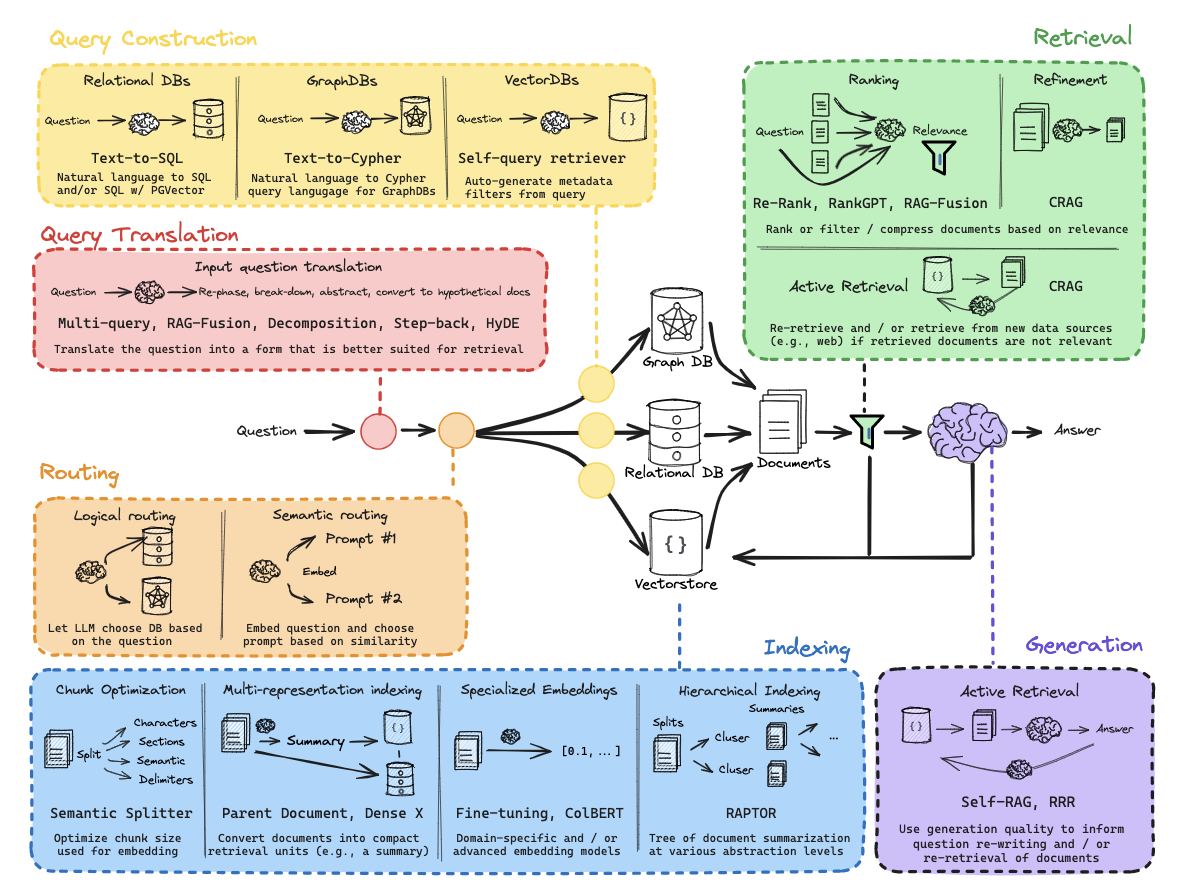

In [1]:
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

(2) LangSmith

https://docs.smith.langchain.com/

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

langchain_api_key=os.environ['langchain_api_key']

(3) API-KEY

In [3]:
zhipu_api_key = os.environ['ZHIPUAI_API_KEY']

# Part1 overview

https://python.langchain.com/v0.1/docs/use_cases/question_answering/quickstart/

In [4]:
from langchain_community.chat_models import ChatZhipuAI
from langchain_community.chat_models import ChatSparkLLM

In [15]:
zhipuai_chat = ChatZhipuAI(
    temperature=0.5, api_key=zhipu_api_key, model="glm-3-turbo"
)

In [6]:
zhipuai_chat.invoke("你好")

AIMessage(content='你好👋！我是人工智能助手智谱清言（ChatGLM），很高兴见到你，欢迎问我任何问题。', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 6, 'total_tokens': 36}, 'model_name': 'glm-3-turbo', 'finish_reason': 'stop'}, id='run-2ac493de-9f28-4f2a-8040-872fe3c3abb5-0')

In [7]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.embeddings import ZhipuAIEmbeddings
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [10]:
### indexing ###

# NOTE: 需要外网
# 加载文档
loader = WebBaseLoader(
    web_path=("https://lilianweng.github.io/posts/2023-06-23-agent/"),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    )
)

docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# print(len(splits))


In [11]:
# Embed
vectorstore = Chroma.from_documents(documents=splits,
                                   embedding=HuggingFaceEmbeddings(model_name='D:/code/models/M3E/xrunda/m3e-base/'))
retriever = vectorstore.as_retriever()
# as_retriever 方法是一个用于将 VectorStore 对象转换为 VectorStoreRetriever 对象的便捷方法。
# VectorStoreRetriever 是一个检索类，用于从向量存储中查找和检索最相关的文档。这个方法接受多个可选参数来配置检索的行为



D:\Python\envs\py310\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


In [14]:
# !pip install langchainhub

# Prompt
prompt = hub.pull("rlm/rag-prompt")  # 加载prompt模版
print(prompt)

D:\Python\envs\py310\lib\site-packages\langchain\hub.py:86: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = client.pull_repo(owner_repo_commit)


input_variables=['context', 'question'] metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]


In [16]:
#LLM
llm = ChatZhipuAI(
    temperature=0.5, api_key=zhipu_api_key, model="glm-3-turbo"
)

# post-precessing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()} 
    | prompt 
    | llm 
    | StrOutputParser()
)

rag_chain.invoke("what is task Decomposition?")

# 数据流：
# retriver先运行，检索回来信息
# 检索回来的信息给 format_docs，组装信息
# 组装信息后填到context Key里，连同 question Key内容一起给 prompt
# prompt 给 llm
# llm 结果给 StrOutputParser

'Task Decomposition is the process of breaking down complex tasks into smaller, simpler steps to facilitate better planning, understanding, and execution. It can be achieved through various methods such as LLM prompting, task-specific instructions, or human inputs.'

# Part2 Indexing
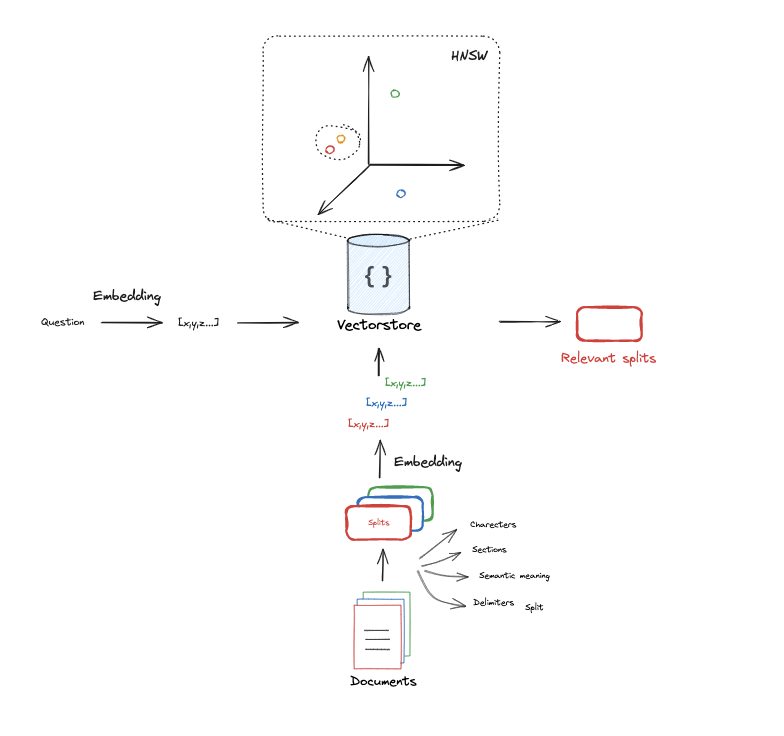

In [17]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."


In [20]:
# !pip install tiktoken

import tiktoken  # openai开源的token编码器

def num_tokens_from_string(string, encoding_nams):
    """返回输出字符串中的token数"""
    encoding = tiktoken.get_encoding(encoding_nams)   # 实例化分词器
    num_tokens = len(encoding.encode(string))         # 编码
    return num_tokens

num_tokens_from_string(question, "cl100k_base")  # cl100k_base指定分词器名称


8

In [25]:
# Text embedding models

embd = HuggingFaceEmbeddings(model_name='D:/code/models/M3E/xrunda/m3e-base/')

query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)  # 向量维度


768

Cosine similarity is reccomended (1 indicates identical) for OpenAI embeddings.

In [26]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)  # L2标准化
    
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity: ", similarity)

Cosine Similarity:  0.8362201548451612


https://python.langchain.com/v0.2/docs/integrations/document_loaders/

In [28]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

blog_docs = loader.load()

Splitter

https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/

> This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [29]:
# split
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 按照token切分，可以避免切分后的文档超过模型token限制
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_overlap=50,
    chunk_size=300
)

# Make splits
splits = text_splitter.split_documents(blog_docs)

print(len(splits))
print(splits[0])

52
page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemor

vectorstores
https://python.langchain.com/v0.2/docs/integrations/vectorstores/

In [30]:
# Index
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_documents(documents=splits,
                                   embedding=HuggingFaceEmbeddings(model_name='D:/code/models/M3E/xrunda/m3e-base/'))

# 转换为检索器
retriever = vectorstore.as_retriever()

# Part 3: Retrieval

In [34]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})  # 返回最相似的topk文档

# 详细参数说明
# https://blog.csdn.net/weixin_46933702/article/details/139334142

In [32]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

D:\Python\envs\py310\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [33]:
len(docs)

1

# Part 4：Generation
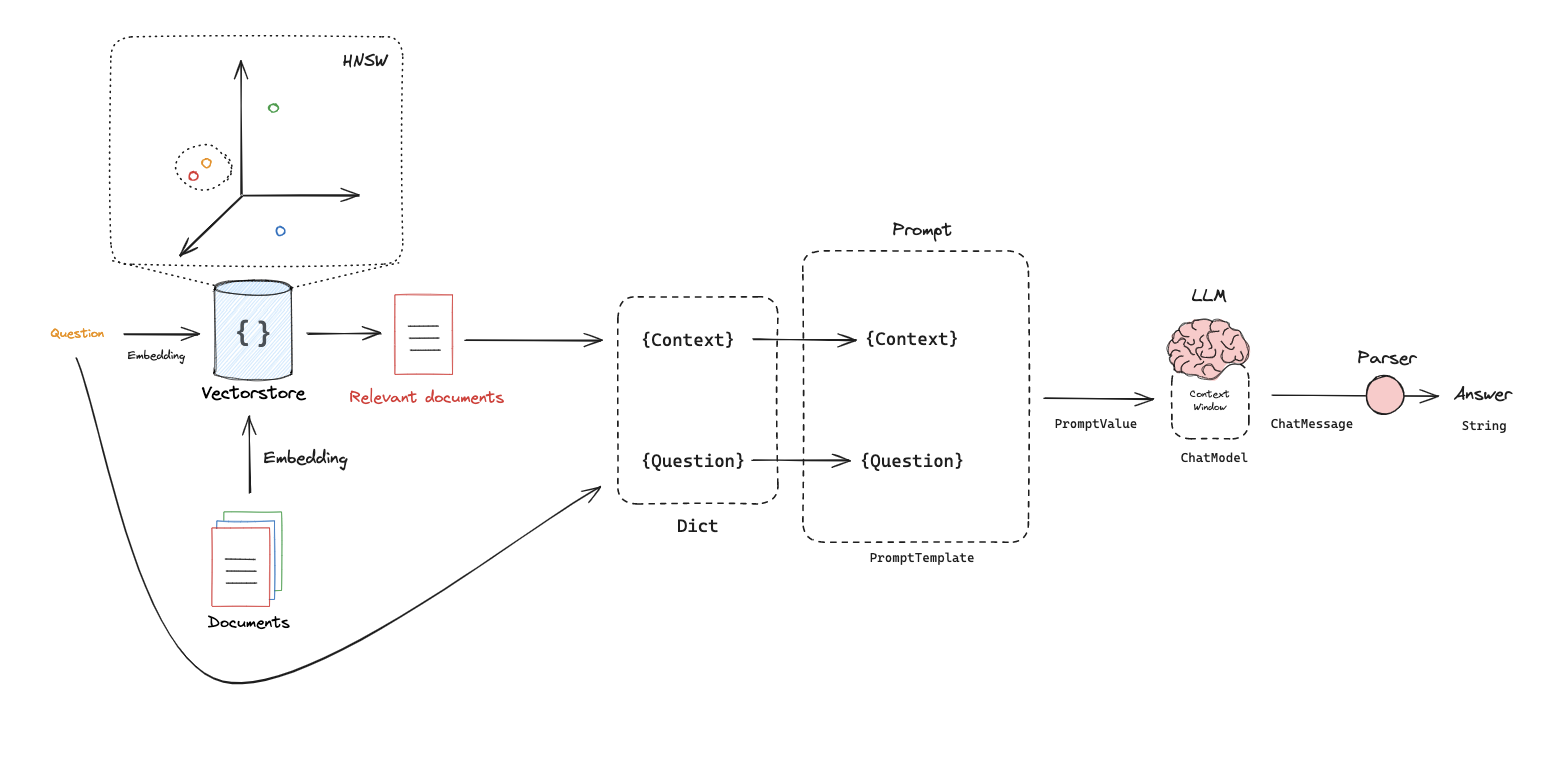

In [35]:
from langchain.prompts import ChatPromptTemplate

#Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'))])

In [36]:
# LLM
from langchain_community.chat_models import ChatZhipuAI

llm = ChatZhipuAI(
    temperature=0, api_key=zhipu_api_key, model="glm-3-turbo"
)

In [37]:
# chain

chain = prompt | llm

In [38]:
# Run

# 这里输入的docs是上面已经检索的来的文档
chain.invoke({"context": docs, "question": "What is Task Decomposition?"})

AIMessage(content="Task Decomposition is the process of breaking down a complicated task into smaller, simpler steps. It is a technique used to enhance model performance on complex tasks and allows for better understanding and interpretation of the model's thinking process. This process can be automated using LLM with simple prompting, task-specific instructions, or human inputs.", response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 378, 'total_tokens': 448}, 'model_name': 'glm-3-turbo', 'finish_reason': 'stop'}, id='run-bf9e27ad-ac0a-4876-a900-75a8f81ed0e1-0')